In [1]:
#Alumnos:
#Bobadilla Catalan, German - 90123
#Briglia, Antonella - 90903
#Calvani, Sergio Alejandro - 98588
#Valdivia, Josue Giovanni - 93075

# Trabajo Práctico Nro 1 - Grupo 10

## 1) Importamos las librerías y cargamos los datos

In [2]:
#Importamos las librerias
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import datetime as datetime
from shapely.geometry import Point
from matplotlib.colors import ListedColormap

%matplotlib inline
plt.style.use('default')
sns.set(style="whitegrid")

In [3]:
#Cargamos el csv
tweets=pd.read_csv('Data/CSV/train.csv')
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
#Veamos los tipos de datos de cada columna
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
#¿Hay valores nulos?
tweets.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [6]:
#Anteriormente vimos que hat nulos en keyword y location, veamos cuantos valores hay
tweets.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
#Cargamos el shp de los estados de usa
#Descargado del link: https://www.arcgis.com/home/item.html?id=f7f805eb65eb4ab787a0a3e1116ca7e5
shp_usa_states="Data/Mapas/Estados_Usa/states.shp"
usa_estados=gpd.read_file(shp_usa_states)
usa_estados=usa_estados[(usa_estados['STATE_NAME']!='Alaska') & (usa_estados['STATE_NAME']!='Hawaii')]
usa_estados.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
1,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...
2,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...
3,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...
4,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...
5,South Dakota,6,46,West North Central,SD,POLYGON ((-102.7883842921169 42.99530336750724...


In [8]:
#Cargamos el csv de ciudades para poder contar mejor la cantidad de tweets por pais
#Descargado del link: 
ciudades=pd.read_csv('Data/CSV/worldcities.csv')
ciudades=ciudades[['city','iso3']]
ciudades.head()

,city,iso3
0,Tokyo,JPN
1,New York,USA
2,Mexico City,MEX
3,Mumbai,IND
4,São Paulo,BRA


Poniendonos a analizar el caso de los valores nulos, se ve que las columnas 'keyword' y 'location' son las que tienen valores nulos, lo cual tiene sentido ya que no siempre se puede obtener la ubicacion del tweet, y en cuanto a 'keyword', si bien es más inusual que tenga valores nulos, tambien tiene sentido ya que no es un campo obligatorio

## 2) Análisis por Localización

In [9]:
#Función que establece si la locacion tiene USA
def TieneUsa(primero,segundo,tercero):
    if((primero=='USA') or (segundo=='USA') or (tercero=='USA')):
        return 1
    else:
        return 0

In [10]:
#Cargamos el mapa del mundo que viene incluido en la libreria de geopandas
mundo=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
mundo.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."


In [11]:
#Separo la locacion por comas para poder separar las ciudades de los paises
separacion_coma=pd.concat([tweets, tweets['location'].str.split(',', expand=True)], axis=1)
separacion_coma.dropna(subset=['location'],inplace=True)
separacion_coma.rename(columns={0:'Primero',1:'Segundo',2:'Tercero'},inplace=True)
separacion_coma.drop(columns={'location',3},inplace=True)
separacion_coma.head()

,id,keyword,text,target,Primero,Segundo,Tercero
31,48,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,Birmingham,None,None
32,49,ablaze,We always try to bring the heavy. #metal #RT h...,0,Est. September 2012 - Bristol,None,None
33,50,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,AFRICA,None,None
34,52,ablaze,Crying out for more! Set me ablaze,0,Philadelphia,PA,None
35,53,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,London,UK,None


In [12]:
#Por si las dudas, borro el espacio que puede llegar a aparecer en el principio
separacion_coma['Primero']=separacion_coma['Primero'].str.lstrip(' ')
separacion_coma['Segundo']=separacion_coma['Segundo'].str.lstrip(' ')
separacion_coma['Tercero']=separacion_coma['Tercero'].str.lstrip(' ')

In [13]:
#Lo mismo que arriba pero al final
separacion_coma['Primero']=separacion_coma['Primero'].str.rstrip(' ')
separacion_coma['Segundo']=separacion_coma['Segundo'].str.rstrip(' ')
separacion_coma['Tercero']=separacion_coma['Tercero'].str.rstrip(' ')

In [14]:
#Me fijo si en alguna de esas tres columnas se encuentra el valor USA
separacion_coma['Es_USA']=separacion_coma.apply(lambda x: TieneUsa(x['Primero'],x['Segundo'],x['Tercero']),axis=1)

In [18]:
#Me quedo con los que su target es real y falso
separacion_coma_real=separacion_coma[(separacion_coma['target']==1)]
separacion_coma_falso=separacion_coma[(separacion_coma['target']==0)]

Hacemos un value counts por la separación

In [28]:
cantidad_primero=separacion_coma['Primero'].value_counts().reset_index()
cantidad_primero.rename(columns={'index':'name','Primero':'Cantidad_primero'},inplace=True)
cantidad_primero_real=separacion_coma_real['Primero'].value_counts().reset_index()
cantidad_primero_real.rename(columns={'index':'name','Primero':'Cantidad_primero_real'},inplace=True)
cantidad_primero_falso=separacion_coma_falso['Primero'].value_counts().reset_index()
cantidad_primero_falso.rename(columns={'index':'name','Primero':'Cantidad_primero_falso'},inplace=True)
cantidad_primero=pd.merge(cantidad_primero,cantidad_primero_real,on='name',how='left')
cantidad_primero=pd.merge(cantidad_primero,cantidad_primero_falso,on='name',how='left')
cantidad_primero.head()

,name,Cantidad_primero,Cantidad_primero_real,Cantidad_primero_falso
0,USA,110,70.0,40.0
1,New York,97,26.0,71.0
2,London,71,25.0,46.0
3,United States,50,27.0,23.0
4,Los Angeles,47,17.0,30.0


In [36]:
cantidad_segundo=separacion_coma['Segundo'].value_counts().reset_index()
cantidad_segundo.rename(columns={'index':'name','Segundo':'Cantidad_segundo'},inplace=True)
cantidad_segundo_real=separacion_coma_real['Segundo'].value_counts().reset_index()
cantidad_segundo_real.rename(columns={'index':'name','Segundo':'Cantidad_segundo_real'},inplace=True)
cantidad_segundo_falso=separacion_coma_falso['Segundo'].value_counts().reset_index()
cantidad_segundo_falso.rename(columns={'index':'name','Segundo':'Cantidad_segundo_falso'},inplace=True)
cantidad_segundo=pd.merge(cantidad_segundo,cantidad_segundo_real,on='name',how='left')
cantidad_segundo=pd.merge(cantidad_segundo,cantidad_segundo_falso,on='name',how='left')
cantidad_segundo.head()

,name,Cantidad_segundo,Cantidad_segundo_real,Cantidad_segundo_falso
0,CA,123,51.0,72.0
1,USA,104,34.0,70.0
2,NY,51,19.0,32.0
3,TX,50,20.0,30.0
4,England,48,12.0,36.0


In [30]:
cantidad_tercero=separacion_coma['Tercero'].value_counts().reset_index()
cantidad_tercero.rename(columns={'index':'name','Tercero':'Cantidad_tercero'},inplace=True)
cantidad_tercero_real=separacion_coma_real['Tercero'].value_counts().reset_index()
cantidad_tercero_real.rename(columns={'index':'name','Tercero':'Cantidad_tercero_real'},inplace=True)
cantidad_tercero_falso=separacion_coma_falso['Tercero'].value_counts().reset_index()
cantidad_tercero_falso.rename(columns={'index':'name','Tercero':'Cantidad_tercero_falso'},inplace=True)
cantidad_tercero=pd.merge(cantidad_tercero,cantidad_tercero_real,on='name',how='left')
cantidad_tercero=pd.merge(cantidad_tercero,cantidad_tercero_falso,on='name',how='left')
cantidad_tercero.head()

,name,Cantidad_tercero,Cantidad_tercero_real,Cantidad_tercero_falso
0,Canada,17,11.0,6.0
1,USA,14,11.0,3.0
2,UK,6,2.0,4.0
3,Australia,5,3.0,2.0
4,CA,3,2.0,1.0


Ahora bien, puede suceder que no haya ninguna coma y que en la locacion aparezca directamente el nombre o abreviación del Pais, o bien que se encuentre de la manera Estado,Pais, o tambien Ciudad,Estado,Pais, por lo que hay que contar por todas las separaciones. Luego veremos el caso específico de Estados Unidos, ya que, al ser uno de los principales paises del mundo en relación al foco de las noticias, vamos a analizar sus estados de manera independiente

### 2.2) Cantidad de Tweets por País

#### 2.2.1) Contar por País

In [33]:
cantidad_pais_primero=pd.merge(mundo,cantidad_primero,on='name',how='left')
cantidad_pais_primero.rename(columns={'name':'Pais','iso_a3':'name'},inplace=True)
cantidad_pais_primero=pd.merge(cantidad_pais_primero,cantidad_primero,on='name',how='left')
cantidad_pais_primero.fillna(value={'Cantidad_primero_x':0,'Cantidad_primero_real_x':0,'Cantidad_primero_falso_x':0,'Cantidad_primero_y':0,'Cantidad_primero_real_y':0,'Cantidad_primero_falso_y':0},inplace=True)
cantidad_pais_primero['Cantidad_primero']=cantidad_pais_primero['Cantidad_primero_x']+cantidad_pais_primero['Cantidad_primero_y']
cantidad_pais_primero['Cantidad_primero_real']=cantidad_pais_primero['Cantidad_primero_real_x']+cantidad_pais_primero['Cantidad_primero_real_y']
cantidad_pais_primero['Cantidad_primero_falso']=cantidad_pais_primero['Cantidad_primero_falso_x']+cantidad_pais_primero['Cantidad_primero_falso_y']
cantidad_pais_primero.drop(columns={'Cantidad_primero_x','Cantidad_primero_real_x','Cantidad_primero_falso_x','Cantidad_primero_y','Cantidad_primero_real_y','Cantidad_primero_falso_y'},inplace=True)
cantidad_pais_primero.head()

,pop_est,continent,Pais,name,gdp_md_est,geometry,Cantidad_primero,Cantidad_primero_real,Cantidad_primero_falso
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555...",0.0,0.0,0.0
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...,0.0,0.0,0.0
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...,0.0,0.0,0.0
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974...",30.0,13.0,17.0
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49....",112.0,72.0,40.0


In [39]:
cantidad_pais_segundo=pd.merge(mundo,cantidad_segundo,on='name',how='left')
cantidad_pais_segundo.rename(columns={'name':'Pais','iso_a3':'name'},inplace=True)
cantidad_pais_segundo=pd.merge(cantidad_pais_segundo,cantidad_segundo,on='name',how='left')
cantidad_pais_segundo.fillna(value={'Cantidad_segundo_x':0,'Cantidad_segundo_real_x':0,'Cantidad_segundo_falso_x':0,'Cantidad_segundo_y':0,'Cantidad_segundo_real_y':0,'Cantidad_segundo_falso_y':0},inplace=True)
cantidad_pais_segundo['Cantidad_segundo']=cantidad_pais_segundo['Cantidad_segundo_x']+cantidad_pais_segundo['Cantidad_segundo_y']
cantidad_pais_segundo['Cantidad_segundo_real']=cantidad_pais_segundo['Cantidad_segundo_real_x']+cantidad_pais_segundo['Cantidad_segundo_real_y']
cantidad_pais_segundo['Cantidad_segundo_falso']=cantidad_pais_segundo['Cantidad_segundo_falso_x']+cantidad_pais_segundo['Cantidad_segundo_falso_y']
cantidad_pais_segundo.drop(columns={'Cantidad_segundo_x','Cantidad_segundo_real_x','Cantidad_segundo_falso_x','Cantidad_segundo_y','Cantidad_segundo_real_y','Cantidad_segundo_falso_y'},inplace=True)
cantidad_pais_segundo=cantidad_pais_segundo[['Pais','Cantidad_segundo','Cantidad_segundo_real','Cantidad_segundo_falso']]
cantidad_pais_segundo.head()

,Pais,Cantidad_segundo,Cantidad_segundo_real,Cantidad_segundo_falso
0,Fiji,0.0,0.0,0.0
1,Tanzania,0.0,0.0,0.0
2,W. Sahara,0.0,0.0,0.0
3,Canada,18.0,7.0,11.0
4,United States of America,104.0,34.0,70.0


In [40]:
cantidad_pais_tercero=pd.merge(mundo,cantidad_tercero,on='name',how='left')
cantidad_pais_tercero.rename(columns={'name':'Pais','iso_a3':'name'},inplace=True)
cantidad_pais_tercero=pd.merge(cantidad_pais_tercero,cantidad_tercero,on='name',how='left')
cantidad_pais_tercero.fillna(value={'Cantidad_tercero_x':0,'Cantidad_tercero_real_x':0,'Cantidad_tercero_falso_x':0,'Cantidad_tercero_y':0,'Cantidad_tercero_real_y':0,'Cantidad_tercero_falso_y':0},inplace=True)
cantidad_pais_tercero['Cantidad_tercero']=cantidad_pais_tercero['Cantidad_tercero_x']+cantidad_pais_tercero['Cantidad_tercero_y']
cantidad_pais_tercero['Cantidad_tercero_real']=cantidad_pais_tercero['Cantidad_tercero_real_x']+cantidad_pais_tercero['Cantidad_tercero_real_y']
cantidad_pais_tercero['Cantidad_tercero_falso']=cantidad_pais_tercero['Cantidad_tercero_falso_x']+cantidad_pais_tercero['Cantidad_tercero_falso_y']
cantidad_pais_tercero.drop(columns={'Cantidad_tercero_x','Cantidad_tercero_real_x','Cantidad_tercero_falso_x','Cantidad_tercero_y','Cantidad_tercero_real_y','Cantidad_tercero_falso_y'},inplace=True)
cantidad_pais_tercero=cantidad_pais_tercero[['Pais','Cantidad_tercero','Cantidad_tercero_real','Cantidad_tercero_falso']]
cantidad_pais_tercero.head()

,Pais,Cantidad_tercero,Cantidad_tercero_real,Cantidad_tercero_falso
0,Fiji,0.0,0.0,0.0
1,Tanzania,0.0,0.0,0.0
2,W. Sahara,0.0,0.0,0.0
3,Canada,17.0,11.0,6.0
4,United States of America,14.0,11.0,3.0


In [126]:
cantidad_pais_total=pd.merge(cantidad_pais_primero,cantidad_pais_segundo,on='Pais',how='inner')
cantidad_pais_total=pd.merge(cantidad_pais_total,cantidad_pais_tercero,on='Pais',how='inner')
cantidad_pais_total['Cantidad_total']=cantidad_pais_total['Cantidad_primero']+cantidad_pais_total['Cantidad_segundo']+cantidad_pais_total['Cantidad_tercero']
cantidad_pais_total['Cantidad_real']=cantidad_pais_total['Cantidad_primero_real']+cantidad_pais_total['Cantidad_segundo_real']+cantidad_pais_total['Cantidad_tercero_real']
cantidad_pais_total['Cantidad_falso']=cantidad_pais_total['Cantidad_primero_falso']+cantidad_pais_total['Cantidad_segundo_falso']+cantidad_pais_total['Cantidad_tercero_falso']
cantidad_pais_total.drop(columns={'Cantidad_primero','Cantidad_segundo','Cantidad_tercero','Cantidad_primero_real','Cantidad_segundo_real','Cantidad_tercero_real','Cantidad_primero_falso','Cantidad_segundo_falso','Cantidad_tercero_falso'},inplace=True)
cantidad_pais_total.head()

,pop_est,continent,Pais,name,gdp_md_est,geometry,Cantidad_total,Cantidad_real,Cantidad_falso
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555...",0.0,0.0,0.0
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...,0.0,0.0,0.0
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...,0.0,0.0,0.0
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974...",65.0,31.0,34.0
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49....",230.0,117.0,113.0


A continuación contaremos la cantidad de veces que aparece una ciudad para tener con mayor exactitud la cantidad de tweets por país

#### 2.2.2) Contar por Ciudad

En esta caso, a Estados Unidos se lo excluye por el simple hecho de que vamos a hacer un análisis más exhaustivo más adelante

In [59]:
ciudades_sin_usa=ciudades[(ciudades['iso3']!='USA')]
ciudades_sin_usa.head()

,city,iso3
0,Tokyo,JPN
2,Mexico City,MEX
3,Mumbai,IND
4,São Paulo,BRA
5,Delhi,IND


In [45]:
ciudades_sin_usa_primero=ciudades[(ciudades['iso3']!='USA')].copy()
ciudades_sin_usa_primero.rename(columns={'city':'name'},inplace=True)
cantidad_ciudad_primero=pd.merge(ciudades_sin_usa_primero,cantidad_primero,on='name',how='left')
cantidad_ciudad_primero.fillna(value={'Cantidad_primero':0,'Cantidad_primero_real':0,'Cantidad_primero_falso':0},inplace=True)
cantidad_ciudad_primero.rename(columns={'name':'city','iso3':'name'},inplace=True)
cantidad_ciudad_primero.head()

,city,name,Cantidad_primero,Cantidad_primero_real,Cantidad_primero_falso
0,Tokyo,JPN,4.0,2.0,2.0
1,Mexico City,MEX,1.0,0.0,1.0
2,Mumbai,IND,29.0,24.0,5.0
3,São Paulo,BRA,0.0,0.0,0.0
4,Delhi,IND,2.0,0.0,2.0


In [46]:
ciudades_sin_usa_segundo=ciudades[(ciudades['iso3']!='USA')].copy()
ciudades_sin_usa_segundo.rename(columns={'city':'name'},inplace=True)
cantidad_ciudad_segundo=pd.merge(ciudades_sin_usa_segundo,cantidad_segundo,on='name',how='left')
cantidad_ciudad_segundo.fillna(value={'Cantidad_segundo':0,'Cantidad_segundo_real':0,'Cantidad_segundo_falso':0},inplace=True)
cantidad_ciudad_segundo.rename(columns={'name':'city','iso3':'name'},inplace=True)
cantidad_ciudad_segundo.head()

,city,name,Cantidad_segundo,Cantidad_segundo_real,Cantidad_segundo_falso
0,Tokyo,JPN,2.0,1.0,1.0
1,Mexico City,MEX,0.0,0.0,0.0
2,Mumbai,IND,0.0,0.0,0.0
3,São Paulo,BRA,0.0,0.0,0.0
4,Delhi,IND,2.0,1.0,1.0


In [47]:
ciudades_sin_usa_tercero=ciudades[(ciudades['iso3']!='USA')].copy()
ciudades_sin_usa_tercero.rename(columns={'city':'name'},inplace=True)
cantidad_ciudad_tercero=pd.merge(ciudades_sin_usa_tercero,cantidad_tercero,on='name',how='left')
cantidad_ciudad_tercero.fillna(value={'Cantidad_tercero':0,'Cantidad_tercero_real':0,'Cantidad_tercero_falso':0},inplace=True)
cantidad_ciudad_tercero.rename(columns={'name':'city','iso3':'name'},inplace=True)
cantidad_ciudad_tercero.head()

,city,name,Cantidad_tercero,Cantidad_tercero_real,Cantidad_tercero_falso
0,Tokyo,JPN,1.0,0.0,1.0
1,Mexico City,MEX,0.0,0.0,0.0
2,Mumbai,IND,0.0,0.0,0.0
3,São Paulo,BRA,0.0,0.0,0.0
4,Delhi,IND,0.0,0.0,0.0


In [53]:
cantidad_ciudad_sin_usa=pd.merge(cantidad_ciudad_primero,cantidad_ciudad_segundo,on='city',how='inner')
cantidad_ciudad_sin_usa=pd.merge(cantidad_ciudad_sin_usa,cantidad_ciudad_tercero,on='city',how='inner')
cantidad_ciudad_sin_usa['Cantidad_total']=cantidad_ciudad_sin_usa['Cantidad_primero']+cantidad_ciudad_sin_usa['Cantidad_segundo']+cantidad_ciudad_sin_usa['Cantidad_tercero']
cantidad_ciudad_sin_usa['Cantidad_real']=cantidad_ciudad_sin_usa['Cantidad_primero_real']+cantidad_ciudad_sin_usa['Cantidad_segundo_real']+cantidad_ciudad_sin_usa['Cantidad_tercero_real']
cantidad_ciudad_sin_usa['Cantidad_falso']=cantidad_ciudad_sin_usa['Cantidad_primero_falso']+cantidad_ciudad_sin_usa['Cantidad_segundo_falso']+cantidad_ciudad_sin_usa['Cantidad_tercero_falso']
cantidad_ciudad_sin_usa.drop(columns={'Cantidad_primero','Cantidad_segundo','Cantidad_tercero','Cantidad_primero_real','Cantidad_segundo_real','Cantidad_tercero_real','Cantidad_primero_falso','Cantidad_segundo_falso','Cantidad_tercero_falso','name_x','name_y'},inplace=True)
cantidad_ciudad_sin_usa.head()

,city,name,Cantidad_total,Cantidad_real,Cantidad_falso
0,Tokyo,JPN,7.0,3.0,4.0
1,Mexico City,MEX,1.0,0.0,1.0
2,Mumbai,IND,29.0,24.0,5.0
3,São Paulo,BRA,0.0,0.0,0.0
4,Delhi,IND,4.0,1.0,3.0


In [61]:
cantidad_ciudad_sin_usa_total=cantidad_ciudad_sin_usa.groupby(['city']).agg({'Cantidad_total':'mean'})
cantidad_ciudad_sin_usa_real=cantidad_ciudad_sin_usa.groupby(['city']).agg({'Cantidad_real':'mean'})
cantidad_ciudad_sin_usa_falso=cantidad_ciudad_sin_usa.groupby(['city']).agg({'Cantidad_falso':'mean'})
cantidad_ciudad_sin_usa_total=cantidad_ciudad_sin_usa_total.reset_index()
cantidad_ciudad_sin_usa_real=cantidad_ciudad_sin_usa_real.reset_index()
cantidad_ciudad_sin_usa_falso=cantidad_ciudad_sin_usa_falso.reset_index()
cantidad_ciudad_sin_usa=pd.merge(cantidad_ciudad_sin_usa_total,cantidad_ciudad_sin_usa_real,on='city',how='inner')
cantidad_ciudad_sin_usa=pd.merge(cantidad_ciudad_sin_usa,cantidad_ciudad_sin_usa_falso,on='city',how='inner')
cantidad_ciudad_sin_usa=pd.merge(cantidad_ciudad_sin_usa,ciudades_sin_usa,on='city',how='inner')
cantidad_ciudad_sin_usa.rename(columns={'iso3':'name'},inplace=True)
cantidad_ciudad_sin_usa.head()

,city,Cantidad_total,Cantidad_real,Cantidad_falso,name
0,A Coruña,0.0,0.0,0.0,ESP
1,Aalborg,0.0,0.0,0.0,DNK
2,Aarau,0.0,0.0,0.0,CHE
3,Aarau,0.0,0.0,0.0,CHE
4,Aarhus,1.0,0.0,1.0,DNK


In [70]:
cantidad_ciudad_pais_total=cantidad_ciudad_sin_usa.groupby(['name']).agg({'Cantidad_total':'sum'})
cantidad_ciudad_pais_real=cantidad_ciudad_sin_usa.groupby(['name']).agg({'Cantidad_real':'sum'})
cantidad_ciudad_pais_falso=cantidad_ciudad_sin_usa.groupby(['name']).agg({'Cantidad_falso':'sum'})
cantidad_ciudad_pais_total=cantidad_ciudad_pais_total.reset_index()
cantidad_ciudad_pais_real=cantidad_ciudad_pais_real.reset_index()
cantidad_ciudad_pais_falso=cantidad_ciudad_pais_falso.reset_index()
cantidad_ciudad_pais=pd.merge(cantidad_ciudad_pais_total,cantidad_ciudad_pais_real,on='name',how='left')
cantidad_ciudad_pais=pd.merge(cantidad_ciudad_pais,cantidad_ciudad_pais_falso,on='name',how='left')
cantidad_ciudad_pais.head()

,name,Cantidad_total,Cantidad_real,Cantidad_falso
0,ABW,0.0,0.0,0.0
1,AFG,1.0,0.0,1.0
2,AGO,0.0,0.0,0.0
3,ALB,0.0,0.0,0.0
4,AND,0.0,0.0,0.0


In [127]:
cantidad_pais_total=pd.merge(cantidad_pais_total,cantidad_ciudad_pais,on='name',how='left')
cantidad_pais_total.fillna(value={'Cantidad_total_y':0,'Cantidad_real_y':0,'Cantidad_falso_y':0},inplace=True)
cantidad_pais_total['Cantidad_total']=cantidad_pais_total['Cantidad_total_x']+cantidad_pais_total['Cantidad_total_y']
cantidad_pais_total['Cantidad_real']=cantidad_pais_total['Cantidad_real_x']+cantidad_pais_total['Cantidad_real_y']
cantidad_pais_total['Cantidad_falso']=cantidad_pais_total['Cantidad_falso_x']+cantidad_pais_total['Cantidad_falso_y']
cantidad_pais_total.drop(columns={'Cantidad_total_x','Cantidad_total_y','Cantidad_real_x','Cantidad_real_y','Cantidad_falso_x','Cantidad_falso_y'},inplace=True)
cantidad_pais_total.head()

,pop_est,continent,Pais,name,gdp_md_est,geometry,Cantidad_total,Cantidad_real,Cantidad_falso
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555...",1.0,0.0,1.0
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...,0.0,0.0,0.0
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...,0.0,0.0,0.0
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974...",284.0,139.0,145.0
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49....",230.0,117.0,113.0


#### 2.2.3) Estados Sin USA

In [83]:
estados_sin_usa_total=separacion_coma[(separacion_coma['Es_USA']==0)]
estados_sin_usa_real=separacion_coma_real[(separacion_coma_real['Es_USA']==0)]
estados_sin_usa_falso=separacion_coma_falso[(separacion_coma_falso['Es_USA']==0)]
cantidad_primero_sin_usa_total=estados_sin_usa_total['Primero'].value_counts().reset_index()
cantidad_primero_sin_usa_total.rename(columns={'index':'name','Primero':'Cantidad_primero_total'},inplace=True)
cantidad_primero_sin_usa_real=estados_sin_usa_real['Primero'].value_counts().reset_index()
cantidad_primero_sin_usa_real.rename(columns={'index':'name','Primero':'Cantidad_primero_real'},inplace=True)
cantidad_primero_sin_usa_falso=estados_sin_usa_falso['Primero'].value_counts().reset_index()
cantidad_primero_sin_usa_falso.rename(columns={'index':'name','Primero':'Cantidad_primero_falso'},inplace=True)
cantidad_primero_sin_usa=pd.merge(cantidad_primero_sin_usa_total,cantidad_primero_sin_usa_real,on='name',how='left')
cantidad_primero_sin_usa=pd.merge(cantidad_primero_sin_usa,cantidad_primero_sin_usa_falso,on='name',how='left')
cantidad_primero_sin_usa.head()

,name,Cantidad_primero_total,Cantidad_primero_real,Cantidad_primero_falso
0,New York,92,25.0,67.0
1,London,71,25.0,46.0
2,United States,50,27.0,23.0
3,Los Angeles,46,17.0,29.0
4,Washington,43,30.0,13.0


In [93]:
cantidad_segundo_sin_usa_total=estados_sin_usa_total['Segundo'].value_counts().reset_index()
cantidad_segundo_sin_usa_total.rename(columns={'index':'name','Segundo':'Cantidad_segundo_total'},inplace=True)
cantidad_segundo_sin_usa_real=estados_sin_usa_real['Segundo'].value_counts().reset_index()
cantidad_segundo_sin_usa_real.rename(columns={'index':'name','Segundo':'Cantidad_segundo_real'},inplace=True)
cantidad_segundo_sin_usa_falso=estados_sin_usa_falso['Segundo'].value_counts().reset_index()
cantidad_segundo_sin_usa_falso.rename(columns={'index':'name','Segundo':'Cantidad_segundo_falso'},inplace=True)
cantidad_segundo_sin_usa=pd.merge(cantidad_segundo_sin_usa_total,cantidad_segundo_sin_usa_real,on='name',how='left')
cantidad_segundo_sin_usa=pd.merge(cantidad_segundo_sin_usa,cantidad_segundo_sin_usa_falso,on='name',how='left')
cantidad_segundo_sin_usa.head()

,name,Cantidad_segundo_total,Cantidad_segundo_real,Cantidad_segundo_falso
0,CA,120,49.0,71.0
1,NY,51,19.0,32.0
2,TX,50,20.0,30.0
3,England,48,12.0,36.0
4,FL,43,17.0,26.0


In [97]:
cantidad_tercero_sin_usa_total=estados_sin_usa_total['Tercero'].value_counts().reset_index()
cantidad_tercero_sin_usa_total.rename(columns={'index':'name','Tercero':'Cantidad_tercero_total'},inplace=True)
cantidad_tercero_sin_usa_real=estados_sin_usa_real['Tercero'].value_counts().reset_index()
cantidad_tercero_sin_usa_real.rename(columns={'index':'name','Tercero':'Cantidad_tercero_real'},inplace=True)
cantidad_tercero_sin_usa_falso=estados_sin_usa_falso['Tercero'].value_counts().reset_index()
cantidad_tercero_sin_usa_falso.rename(columns={'index':'name','Tercero':'Cantidad_tercero_falso'},inplace=True)
cantidad_tercero_sin_usa=pd.merge(cantidad_tercero_sin_usa_total,cantidad_tercero_sin_usa_real,on='name',how='left')
cantidad_tercero_sin_usa=pd.merge(cantidad_tercero_sin_usa,cantidad_tercero_sin_usa_falso,on='name',how='left')
cantidad_tercero_sin_usa.head()

,name,Cantidad_tercero_total,Cantidad_tercero_real,Cantidad_tercero_falso
0,Canada,17,11.0,6.0
1,UK,6,2.0,4.0
2,Australia,5,3.0,2.0
3,CA,3,2.0,1.0
4,Europe,3,1.0,2.0


In [86]:
usa_estados.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
1,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...
2,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...
3,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...
4,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...
5,South Dakota,6,46,West North Central,SD,POLYGON ((-102.7883842921169 42.99530336750724...


In [89]:
estados_primero_sin_usa=usa_estados.copy()
estados_primero_sin_usa.rename(columns={'STATE_NAME':'name'},inplace=True)
cantidad_estados_primero_sin_usa=pd.merge(estados_primero_sin_usa,cantidad_primero_sin_usa,on='name',how='left')
cantidad_estados_primero_sin_usa.rename(columns={'name':'Estado','STATE_ABBR':'name'},inplace=True)
cantidad_estados_primero_sin_usa=pd.merge(cantidad_estados_primero_sin_usa,cantidad_primero_sin_usa,on='name',how='left')
cantidad_estados_primero_sin_usa.fillna(value={'Cantidad_primero_total_x':0,'Cantidad_primero_real_x':0,'Cantidad_primero_falso_x':0,'Cantidad_primero_total_y':0,'Cantidad_primero_real_y':0,'Cantidad_primero_falso_y':0},inplace=True)
cantidad_estados_primero_sin_usa['Cantidad_primero_total']=cantidad_estados_primero_sin_usa['Cantidad_primero_total_x']+cantidad_estados_primero_sin_usa['Cantidad_primero_total_y']
cantidad_estados_primero_sin_usa['Cantidad_primero_real']=cantidad_estados_primero_sin_usa['Cantidad_primero_real_x']+cantidad_estados_primero_sin_usa['Cantidad_primero_real_y']
cantidad_estados_primero_sin_usa['Cantidad_primero_falso']=cantidad_estados_primero_sin_usa['Cantidad_primero_falso_x']+cantidad_estados_primero_sin_usa['Cantidad_primero_falso_y']
cantidad_estados_primero_sin_usa.drop(columns={'Cantidad_primero_total_x','Cantidad_primero_real_x','Cantidad_primero_falso_x','Cantidad_primero_total_y','Cantidad_primero_real_y','Cantidad_primero_falso_y'},inplace=True)
cantidad_estados_primero_sin_usa.head()

,Estado,DRAWSEQ,STATE_FIPS,SUB_REGION,name,geometry,Cantidad_primero_total,Cantidad_primero_real,Cantidad_primero_falso
0,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...,43.0,30.0,13.0
1,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...,1.0,1.0,0.0
2,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...,0.0,0.0,0.0
3,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...,0.0,0.0,0.0
4,South Dakota,6,46,West North Central,SD,POLYGON ((-102.7883842921169 42.99530336750724...,0.0,0.0,0.0


In [91]:
cantidad_estados_primero_sin_usa_total=cantidad_estados_primero_sin_usa['Cantidad_primero_total'].sum()
cantidad_estados_primero_sin_usa_real=cantidad_estados_primero_sin_usa['Cantidad_primero_real'].sum()
cantidad_estados_primero_sin_usa_falso=cantidad_estados_primero_sin_usa['Cantidad_primero_falso'].sum()

In [94]:
estados_segundo_sin_usa=usa_estados.copy()
estados_segundo_sin_usa.rename(columns={'STATE_NAME':'name'},inplace=True)
cantidad_estados_segundo_sin_usa=pd.merge(estados_segundo_sin_usa,cantidad_segundo_sin_usa,on='name',how='left')
cantidad_estados_segundo_sin_usa.rename(columns={'name':'Estado','STATE_ABBR':'name'},inplace=True)
cantidad_estados_segundo_sin_usa=pd.merge(cantidad_estados_segundo_sin_usa,cantidad_segundo_sin_usa,on='name',how='left')
cantidad_estados_segundo_sin_usa.fillna(value={'Cantidad_segundo_total_x':0,'Cantidad_segundo_real_x':0,'Cantidad_segundo_falso_x':0,'Cantidad_segundo_total_y':0,'Cantidad_segundo_real_y':0,'Cantidad_segundo_falso_y':0},inplace=True)
cantidad_estados_segundo_sin_usa['Cantidad_segundo_total']=cantidad_estados_segundo_sin_usa['Cantidad_segundo_total_x']+cantidad_estados_segundo_sin_usa['Cantidad_segundo_total_y']
cantidad_estados_segundo_sin_usa['Cantidad_segundo_real']=cantidad_estados_segundo_sin_usa['Cantidad_segundo_real_x']+cantidad_estados_segundo_sin_usa['Cantidad_segundo_real_y']
cantidad_estados_segundo_sin_usa['Cantidad_segundo_falso']=cantidad_estados_segundo_sin_usa['Cantidad_segundo_falso_x']+cantidad_estados_segundo_sin_usa['Cantidad_segundo_falso_y']
cantidad_estados_segundo_sin_usa.drop(columns={'Cantidad_segundo_total_x','Cantidad_segundo_real_x','Cantidad_segundo_falso_x','Cantidad_segundo_total_y','Cantidad_segundo_real_y','Cantidad_segundo_falso_y'},inplace=True)
cantidad_estados_segundo_sin_usa.head()

,Estado,DRAWSEQ,STATE_FIPS,SUB_REGION,name,geometry,Cantidad_segundo_total,Cantidad_segundo_real,Cantidad_segundo_falso
0,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...,25.0,9.0,16.0
1,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...,2.0,0.0,2.0
2,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...,3.0,2.0,1.0
3,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...,1.0,0.0,1.0
4,South Dakota,6,46,West North Central,SD,POLYGON ((-102.7883842921169 42.99530336750724...,2.0,1.0,1.0


In [99]:
cantidad_estados_segundo_sin_usa_total=cantidad_estados_segundo_sin_usa['Cantidad_segundo_total'].sum()
cantidad_estados_segundo_sin_usa_real=cantidad_estados_segundo_sin_usa['Cantidad_segundo_real'].sum()
cantidad_estados_segundo_sin_usa_falso=cantidad_estados_segundo_sin_usa['Cantidad_segundo_falso'].sum()

In [100]:
estados_tercero_sin_usa=usa_estados.copy()
estados_tercero_sin_usa.rename(columns={'STATE_NAME':'name'},inplace=True)
cantidad_estados_tercero_sin_usa=pd.merge(estados_tercero_sin_usa,cantidad_tercero_sin_usa,on='name',how='left')
cantidad_estados_tercero_sin_usa.rename(columns={'name':'Estado','STATE_ABBR':'name'},inplace=True)
cantidad_estados_tercero_sin_usa=pd.merge(cantidad_estados_tercero_sin_usa,cantidad_tercero_sin_usa,on='name',how='left')
cantidad_estados_tercero_sin_usa.fillna(value={'Cantidad_tercero_total_x':0,'Cantidad_tercero_real_x':0,'Cantidad_tercero_falso_x':0,'Cantidad_tercero_total_y':0,'Cantidad_tercero_real_y':0,'Cantidad_tercero_falso_y':0},inplace=True)
cantidad_estados_tercero_sin_usa['Cantidad_tercero_total']=cantidad_estados_tercero_sin_usa['Cantidad_tercero_total_x']+cantidad_estados_tercero_sin_usa['Cantidad_tercero_total_y']
cantidad_estados_tercero_sin_usa['Cantidad_tercero_real']=cantidad_estados_tercero_sin_usa['Cantidad_tercero_real_x']+cantidad_estados_tercero_sin_usa['Cantidad_tercero_real_y']
cantidad_estados_tercero_sin_usa['Cantidad_tercero_falso']=cantidad_estados_tercero_sin_usa['Cantidad_tercero_falso_x']+cantidad_estados_tercero_sin_usa['Cantidad_tercero_falso_y']
cantidad_estados_tercero_sin_usa.drop(columns={'Cantidad_tercero_total_x','Cantidad_tercero_real_x','Cantidad_tercero_falso_x','Cantidad_tercero_total_y','Cantidad_tercero_real_y','Cantidad_tercero_falso_y'},inplace=True)
cantidad_estados_tercero_sin_usa.head()

,Estado,DRAWSEQ,STATE_FIPS,SUB_REGION,name,geometry,Cantidad_tercero_total,Cantidad_tercero_real,Cantidad_tercero_falso
0,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...,0.0,0.0,0.0
1,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...,0.0,0.0,0.0
2,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...,0.0,0.0,0.0
3,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...,0.0,0.0,0.0
4,South Dakota,6,46,West North Central,SD,POLYGON ((-102.7883842921169 42.99530336750724...,1.0,1.0,0.0


In [101]:
cantidad_estados_tercero_sin_usa_total=cantidad_estados_tercero_sin_usa['Cantidad_tercero_total'].sum()
cantidad_estados_tercero_sin_usa_real=cantidad_estados_tercero_sin_usa['Cantidad_tercero_real'].sum()
cantidad_estados_tercero_sin_usa_falso=cantidad_estados_tercero_sin_usa['Cantidad_tercero_falso'].sum()

In [104]:
cantidad_estados_sin_usa_total=cantidad_estados_primero_sin_usa_total+cantidad_estados_segundo_sin_usa_total+cantidad_estados_tercero_sin_usa_total
cantidad_estados_sin_usa_real=cantidad_estados_primero_sin_usa_real+cantidad_estados_segundo_sin_usa_real+cantidad_estados_tercero_sin_usa_real
cantidad_estados_sin_usa_falso=cantidad_estados_primero_sin_usa_falso+cantidad_estados_segundo_sin_usa_falso+cantidad_estados_tercero_sin_usa_falso

In [128]:
cantidad_sin_usa=[['USA',cantidad_estados_sin_usa_total,cantidad_estados_sin_usa_real,cantidad_estados_sin_usa_falso]]
cantidad_estados_sin_usa=pd.DataFrame(cantidad_sin_usa,columns=['name','Cantidad_total_sin_usa','Cantidad_real_sin_usa','Cantidad_falso_sin_usa'])
cantidad_pais_total=pd.merge(cantidad_pais_total,cantidad_estados_sin_usa,on='name',how='left')
cantidad_pais_total.fillna(value={'Cantidad_total_sin_usa':0,'Cantidad_real_sin_usa':0,'Cantidad_falso_sin_usa':0},inplace=True)
cantidad_pais_total['Cantidad_total']=cantidad_pais_total['Cantidad_total']+cantidad_pais_total['Cantidad_total_sin_usa']
cantidad_pais_total['Cantidad_real']=cantidad_pais_total['Cantidad_real']+cantidad_pais_total['Cantidad_real_sin_usa']
cantidad_pais_total['Cantidad_falso']=cantidad_pais_total['Cantidad_falso']+cantidad_pais_total['Cantidad_falso_sin_usa']
cantidad_pais_total['Promedio_real']=(cantidad_pais_total['Cantidad_real']/cantidad_pais_total['Cantidad_total'])*100
cantidad_pais_total['Promedio_falso']=(cantidad_pais_total['Cantidad_falso']/cantidad_pais_total['Cantidad_total'])*100
cantidad_pais_total.drop(columns={'Cantidad_total_sin_usa','Cantidad_real_sin_usa','Cantidad_falso_sin_usa','Cantidad_real','Cantidad_falso'},inplace=True)
cantidad_pais_total.head()

,pop_est,continent,Pais,name,gdp_md_est,geometry,Cantidad_total,Promedio_real,Promedio_falso
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555...",1.0,0.000000,100.000000
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...,0.0,NaN,NaN
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...,0.0,NaN,NaN
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974...",284.0,48.943662,51.056338
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49....",1477.0,43.872715,56.127285


Text(0.5,1,'Cantidad de Tweets por País')

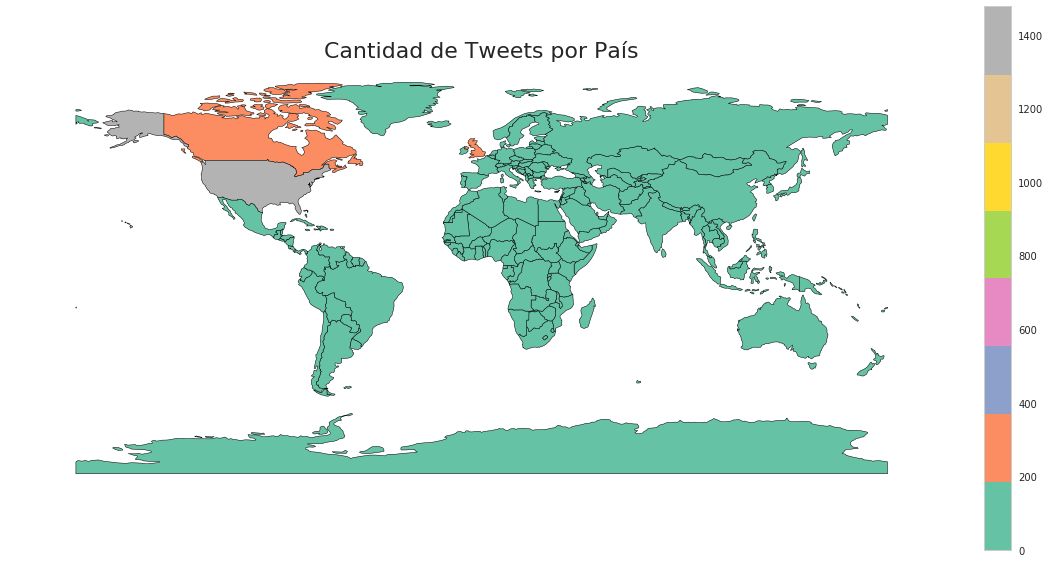

In [129]:
fig, grafico_cantidad_pais = plt.subplots(1, figsize=(20, 10))
cantidad_pais_total.plot(column='Cantidad_total',cmap='Set2', edgecolor='black',ax=grafico_cantidad_pais,legend=True,figsize=(30,30),linewidth=0.5)
grafico_cantidad_pais.axis('off')
grafico_cantidad_pais.set_title("Cantidad de Tweets por País",fontsize=22)

/home/sergio/.local/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Text(0.5,1,'Promedio de Tweets Reales por País')

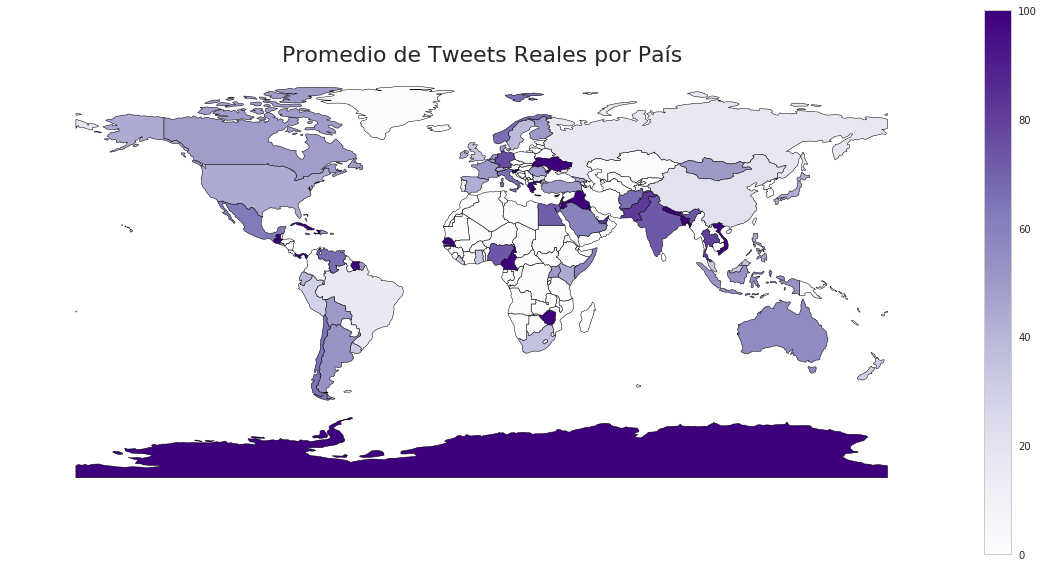

In [130]:
fig, grafico_promedio_real_pais = plt.subplots(1, figsize=(20, 10))
cantidad_pais_total.plot(column='Promedio_real',cmap='Purples', edgecolor='black',ax=grafico_promedio_real_pais,legend=True,figsize=(30,30),linewidth=0.5)
grafico_promedio_real_pais.axis('off')
grafico_promedio_real_pais.set_title("Promedio de Tweets Reales por País",fontsize=22)

/home/sergio/.local/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Text(0.5,1,'Promedio de Tweets Falsos por País')

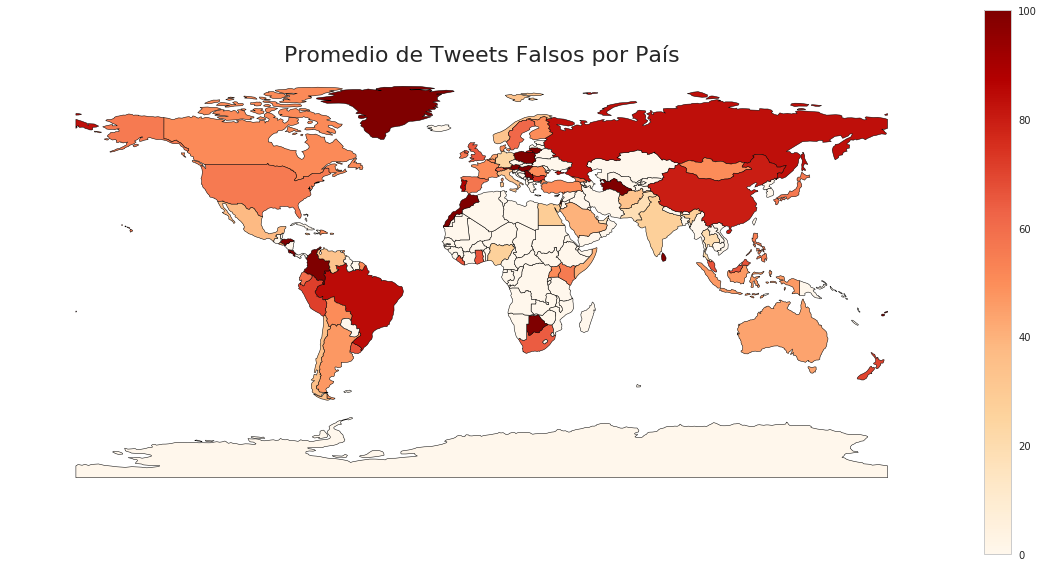

In [131]:
fig, grafico_promedio_falso_pais = plt.subplots(1, figsize=(20, 10))
cantidad_pais_total.plot(column='Promedio_falso',cmap='OrRd', edgecolor='black',ax=grafico_promedio_falso_pais,legend=True,figsize=(30,30),linewidth=0.5)
grafico_promedio_falso_pais.axis('off')
grafico_promedio_falso_pais.set_title("Promedio de Tweets Falsos por País",fontsize=22)

### 2.3 Estados de USA

In [42]:
estados_primero=usa_estados.copy()
estados_primero.rename(columns={'STATE_NAME':'name'},inplace=True)
cantidad_estados_primero=pd.merge(estados_primero,cantidad_primero,on='name',how='left')
cantidad_estados_primero.rename(columns={'name':'Estado','STATE_ABBR':'name'},inplace=True)
cantidad_estados_primero=pd.merge(cantidad_estados_primero,cantidad_primero,on='name',how='left')
cantidad_estados_primero.fillna(value={'cantidad_x':0,'cantidad_y':0},inplace=True)
cantidad_estados_primero['Cantidad_primero']=cantidad_estados_primero['cantidad_x']+cantidad_estados_primero['cantidad_y']
cantidad_estados_primero.drop(columns={'cantidad_x','cantidad_y'},inplace=True)
cantidad_estados_primero.head()

,Estado,DRAWSEQ,STATE_FIPS,SUB_REGION,name,geometry,Cantidad_primero
0,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...,45.0
1,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...,2.0
2,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...,0.0
3,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...,0.0
4,South Dakota,6,46,West North Central,SD,POLYGON ((-102.7883842921169 42.99530336750724...,0.0


In [43]:
estados_segundo=usa_estados.copy()
estados_segundo.rename(columns={'STATE_NAME':'name'},inplace=True)
cantidad_estados_segundo=pd.merge(estados_segundo,cantidad_segundo,on='name',how='left')
cantidad_estados_segundo.rename(columns={'name':'Estado','STATE_ABBR':'name'},inplace=True)
cantidad_estados_segundo=pd.merge(cantidad_estados_segundo,cantidad_segundo,on='name',how='left')
cantidad_estados_segundo.fillna(value={'cantidad_x':0,'cantidad_y':0},inplace=True)
cantidad_estados_segundo['Cantidad_segundo']=cantidad_estados_segundo['cantidad_x']+cantidad_estados_segundo['cantidad_y']
cantidad_estados_segundo.drop(columns={'cantidad_x','cantidad_y'},inplace=True)
cantidad_estados_segundo=cantidad_estados_segundo[['Estado','Cantidad_segundo']]
cantidad_estados_segundo.head()

,Estado,Cantidad_segundo
0,Washington,26.0
1,Montana,2.0
2,Maine,3.0
3,North Dakota,2.0
4,South Dakota,2.0


In [44]:
estados_tercero=usa_estados.copy()
estados_tercero.rename(columns={'STATE_NAME':'name'},inplace=True)
cantidad_estados_tercero=pd.merge(estados_tercero,cantidad_tercero,on='name',how='left')
cantidad_estados_tercero.rename(columns={'name':'Estado','STATE_ABBR':'name'},inplace=True)
cantidad_estados_tercero=pd.merge(cantidad_estados_tercero,cantidad_tercero,on='name',how='left')
cantidad_estados_tercero.fillna(value={'cantidad_x':0,'cantidad_y':0},inplace=True)
cantidad_estados_tercero['Cantidad_tercero']=cantidad_estados_tercero['cantidad_x']+cantidad_estados_tercero['cantidad_y']
cantidad_estados_tercero.drop(columns={'cantidad_x','cantidad_y'},inplace=True)
cantidad_estados_tercero=cantidad_estados_tercero[['Estado','Cantidad_tercero']]
cantidad_estados_tercero.head()

,Estado,Cantidad_tercero
0,Washington,0.0
1,Montana,0.0
2,Maine,0.0
3,North Dakota,0.0
4,South Dakota,1.0


In [45]:
cantidad_estados_total=pd.merge(cantidad_estados_primero,cantidad_estados_segundo,on='Estado',how='inner')
cantidad_estados_total=pd.merge(cantidad_estados_total,cantidad_estados_tercero,on='Estado',how='inner')
cantidad_estados_total['Cantidad_total']=cantidad_estados_total['Cantidad_primero']+cantidad_estados_total['Cantidad_segundo']+cantidad_estados_total['Cantidad_tercero']
cantidad_estados_total.drop(columns={'Cantidad_primero','Cantidad_segundo','Cantidad_tercero'},inplace=True)
cantidad_estados_total.head()

,Estado,DRAWSEQ,STATE_FIPS,SUB_REGION,name,geometry,Cantidad_total
0,Washington,2,53,Pacific,WA,(POLYGON ((-122.4020153103835 48.2252163723779...,71.0
1,Montana,3,30,Mountain,MT,POLYGON ((-111.4754253002074 44.70216236909688...,4.0
2,Maine,4,23,New England,ME,(POLYGON ((-69.77727626137293 44.0741483685119...,3.0
3,North Dakota,5,38,West North Central,ND,POLYGON ((-98.73043728833767 45.93827137024809...,2.0
4,South Dakota,6,46,West North Central,SD,POLYGON ((-102.7883842921169 42.99530336750724...,3.0


Text(0.5,1,'Cantidad de Tweets por Estado en Estados Unidos')

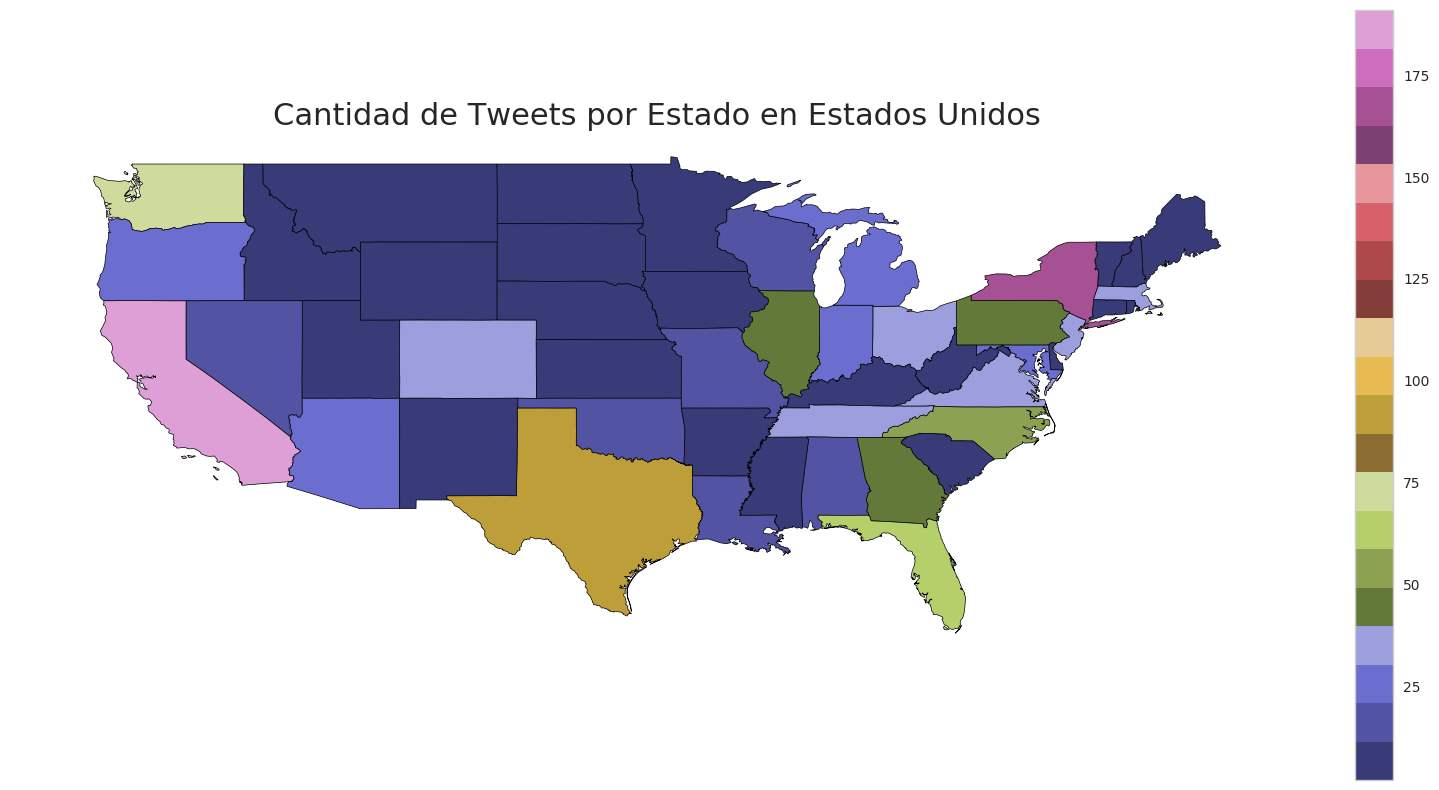

In [46]:
fig, grafico_cantidad_estados_usa = plt.subplots(1, figsize=(20, 10))
cantidad_estados_total.plot(column='Cantidad_total',cmap='tab20b', edgecolor='black',ax=grafico_cantidad_estados_usa,legend=True,figsize=(30,30),linewidth=0.5)
grafico_cantidad_estados_usa.axis('off')
grafico_cantidad_estados_usa.set_title("Cantidad de Tweets por Estado en Estados Unidos",fontsize=22)